<a href="https://colab.research.google.com/github/armangh67/data/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Turbine_Data.csv to Turbine_Data.csv


In [3]:
import io
df2 = pd.read_csv(io.BytesIO(uploaded['Turbine_Data.csv']))
df2.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [4]:
########### Select related columns #############
df_selected = df2[['Unnamed: 0','ActivePower','AmbientTemperatue','WindDirection','WindSpeed']]
df = df_selected.rename(columns = {'Unnamed: 0':'date'})

rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)
df_new = pd.concat((time_df,df_selected),axis =1)
df_new = df_new.set_index(0)
df_new = df_new.drop(['Unnamed: 0'],axis = 1)
dataset = df_new.fillna(0).astype(float)
dataset = dataset.loc['2019-12-17':]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1eea82ed0>,
      dtype=object)

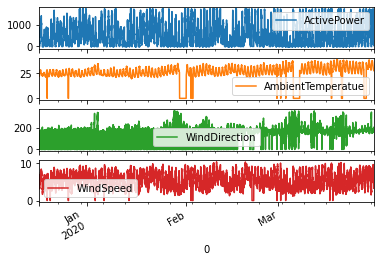

In [5]:
dataset[['ActivePower','AmbientTemperatue','WindDirection','WindSpeed']].plot(subplots = True)


In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(dataset)

In [7]:
features = data_scaled
target = data_scaled[:,0]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 123, shuffle = False)
##### Simulation Parameters ########
win_len = 144
batch_size = 64
num_features = 4
n_hour_prediction = 24    #### how many hours we want to predict ahead #####
n_ahead = n_hour_prediction*6
epochs = 20
train_gen = TimeseriesGenerator(x_train, y_train, length = win_len, sampling_rate = 1 , batch_size = batch_size)
test_gen = TimeseriesGenerator(x_test, y_test, length = win_len, sampling_rate = 1 , batch_size = batch_size)

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='tanh', input_shape = (win_len,num_features), return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.LSTM(128, activation='tanh', return_sequences = True))
model.add(tf.keras.layers.LeakyReLU(alpha = 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, activation='tanh', return_sequences = False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode = 'min')



In [10]:
model.compile(loss = tf.losses.MeanSquaredError(), 
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_gen,epochs=epochs, validation_data=test_gen, shuffle=False, callbacks=[early_stopping])

Epoch 1/20
187/187 [==============================] - 170s 879ms/step - loss: 0.0237 - mean_absolute_error: 0.1128 - val_loss: 0.0159 - val_mean_absolute_error: 0.0884
Epoch 2/20
187/187 [==============================] - 145s 775ms/step - loss: 0.0142 - mean_absolute_error: 0.0849 - val_loss: 0.0111 - val_mean_absolute_error: 0.0700
Epoch 3/20
187/187 [==============================] - 144s 769ms/step - loss: 0.0104 - mean_absolute_error: 0.0720 - val_loss: 0.0094 - val_mean_absolute_error: 0.0674
Epoch 4/20
187/187 [==============================] - 144s 771ms/step - loss: 0.0086 - mean_absolute_error: 0.0647 - val_loss: 0.0082 - val_mean_absolute_error: 0.0644
Epoch 5/20
187/187 [==============================] - 144s 771ms/step - loss: 0.0078 - mean_absolute_error: 0.0615 - val_loss: 0.0073 - val_mean_absolute_error: 0.0597
Epoch 6/20
187/187 [==============================] - 145s 773ms/step - loss: 0.0070 - mean_absolute_error: 0.0580 - val_loss: 0.0074 - val_mean_absolute_error:

In [11]:
model.evaluate_generator(test_gen,verbose= 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.007016466930508614, 0.055069450289011]

In [12]:
pred = model.predict_generator(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [13]:
pred.shape[0]

2880

In [14]:
pred

array([[0.27550215],
       [0.27064902],
       [0.23026437],
       ...,
       [0.06473743],
       [0.05547566],
       [0.06331596]], dtype=float32)

In [15]:
y_test

array([0.12584005, 0.11177365, 0.09883697, ..., 0.03353111, 0.05689067,
       0.06060743])

In [16]:
x_test[:,1:][win_len:]

array([[0.63608083, 0.49859944, 0.53865889],
       [0.6366083 , 0.50513539, 0.51838262],
       [0.63532507, 0.51820728, 0.4629374 ],
       ...,
       [0.72312652, 0.49859944, 0.32226445],
       [0.72967398, 0.53221289, 0.31768264],
       [0.73243824, 0.56862745, 0.33613123]])

In [17]:
df_pred = pd.concat([pd.DataFrame(pred), pd.DataFrame(x_test[:,1:][win_len:])],axis = 1)

In [18]:
rev_trans = scaler.inverse_transform(df_pred)

In [19]:
rev_trans

array([[448.72290774,  24.24330375, 178.        ,   5.56910506],
       [440.13976046,  24.2634074 , 180.33333333,   5.359472  ],
       [368.71627825,  24.214499  , 185.        ,   4.78623311],
       ...,
       [ 75.96866358,  27.56092467, 178.        ,   3.33183875],
       [ 59.58847936,  27.81047156, 190.        ,   3.28446822],
       [ 73.45467332,  27.91582756, 203.        ,   3.47520505]])

In [20]:
df_final = dataset[pred.shape[0]*-1:]

In [21]:
df_final.count()

ActivePower          2880
AmbientTemperatue    2880
WindDirection        2880
WindSpeed            2880
dtype: int64

In [22]:
df_final['Predict'] = rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_final

,ActivePower,AmbientTemperatue,WindDirection,WindSpeed,Predict
0,,,,,
2020-03-11 00:00:00,448.583844,24.243304,178.000000,5.569105,448.722908
2020-03-11 00:10:00,345.986319,24.263407,180.333333,5.359472,440.139760
2020-03-11 00:20:00,213.846619,24.214499,185.000000,4.786233,368.716278
2020-03-11 00:30:00,203.124389,24.231429,185.000000,4.494868,251.801125
2020-03-11 00:40:00,239.335522,24.234613,185.000000,4.860066,210.665673
...,...,...,...,...,...
2020-03-30 23:10:00,70.044465,27.523741,178.000000,3.533445,117.010361
2020-03-30 23:20:00,40.833474,27.602882,178.000000,3.261231,100.993136
2020-03-30 23:30:00,20.777790,27.560925,178.000000,3.331839,75.968664


<function matplotlib.pyplot.show>

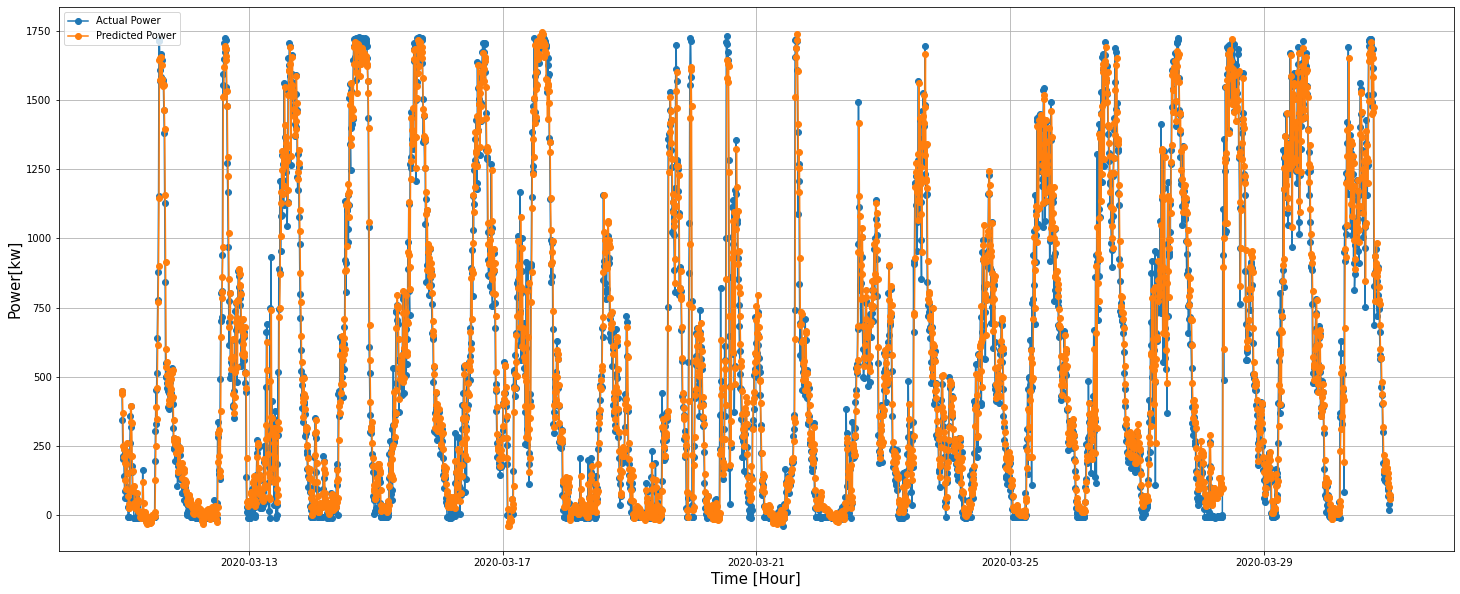

In [24]:
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(25, 10))
plt.plot(df_final.ActivePower, color='C0', marker='o', label='Actual Power')
plt.plot(df_final.Predict, color='C1', marker='o', label='Predicted Power')
plt.xlabel("Time [Hour]", fontsize = 15)
plt.ylabel("Power[kw]",fontsize = 15)
plt.grid()
plt.legend()
plt.show

In [25]:
df_print = df_final.iloc[0:144]

In [26]:
df_print

,ActivePower,AmbientTemperatue,WindDirection,WindSpeed,Predict
0,,,,,
2020-03-11 00:00:00,448.583844,24.243304,178.000000,5.569105,448.722908
2020-03-11 00:10:00,345.986319,24.263407,180.333333,5.359472,440.139760
2020-03-11 00:20:00,213.846619,24.214499,185.000000,4.786233,368.716278
2020-03-11 00:30:00,203.124389,24.231429,185.000000,4.494868,251.801125
2020-03-11 00:40:00,239.335522,24.234613,185.000000,4.860066,210.665673
...,...,...,...,...,...
2020-03-11 23:10:00,125.889932,25.265714,185.000000,4.276316,169.000402
2020-03-11 23:20:00,111.214517,25.168855,185.000000,4.374755,169.194393
2020-03-11 23:30:00,54.767994,25.124966,185.000000,3.856542,158.500563


In [27]:
df_print['hour'] = range(1,len(df_print)+1)
df_print['hour'] = df_print['hour'].astype(float)
df_print['hour']*=1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [28]:
df_print

,ActivePower,AmbientTemperatue,WindDirection,WindSpeed,Predict,hour
0,,,,,,
2020-03-11 00:00:00,448.583844,24.243304,178.000000,5.569105,448.722908,0.166667
2020-03-11 00:10:00,345.986319,24.263407,180.333333,5.359472,440.139760,0.333333
2020-03-11 00:20:00,213.846619,24.214499,185.000000,4.786233,368.716278,0.500000
2020-03-11 00:30:00,203.124389,24.231429,185.000000,4.494868,251.801125,0.666667
2020-03-11 00:40:00,239.335522,24.234613,185.000000,4.860066,210.665673,0.833333
...,...,...,...,...,...,...
2020-03-11 23:10:00,125.889932,25.265714,185.000000,4.276316,169.000402,23.333333
2020-03-11 23:20:00,111.214517,25.168855,185.000000,4.374755,169.194393,23.500000
2020-03-11 23:30:00,54.767994,25.124966,185.000000,3.856542,158.500563,23.666667


<function matplotlib.pyplot.show>

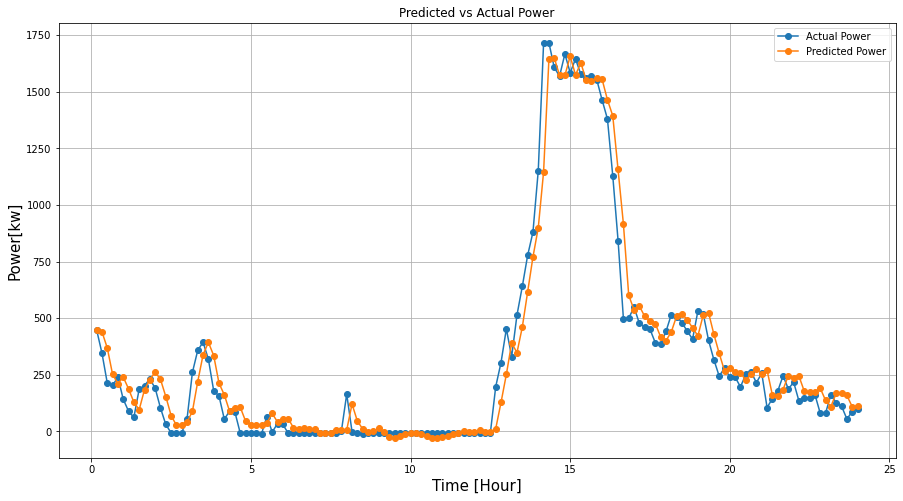

In [29]:

plt.figure(figsize=(15, 8))
plt.plot(df_print.hour, df_print.ActivePower, color='C0', marker='o', label='Actual Power')
plt.plot(df_print.hour, df_print.Predict, color='C1', marker='o', label='Predicted Power')
plt.title('Predicted vs Actual Power')
plt.xlabel("Time [Hour]", fontsize = 15)
plt.ylabel("Power[kw]",fontsize = 15)
plt.grid()
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.legend()
plt.savefig('forecast_example.png')
plt.show

In [30]:
from sklearn.metrics import mean_squared_error
MSE = sqrt(mean_squared_error(df_print['ActivePower'],df_print['Predict'] ))
print("The MSE value is",MSE)

from sklearn.metrics import mean_absolute_percentage_error
MPE = mean_absolute_percentage_error(df_print['ActivePower'],df_print['Predict'] )
print("The MPE value is",MPE)

The MSE value is 100.71536521711529
The MPE value is 2.1228305896822


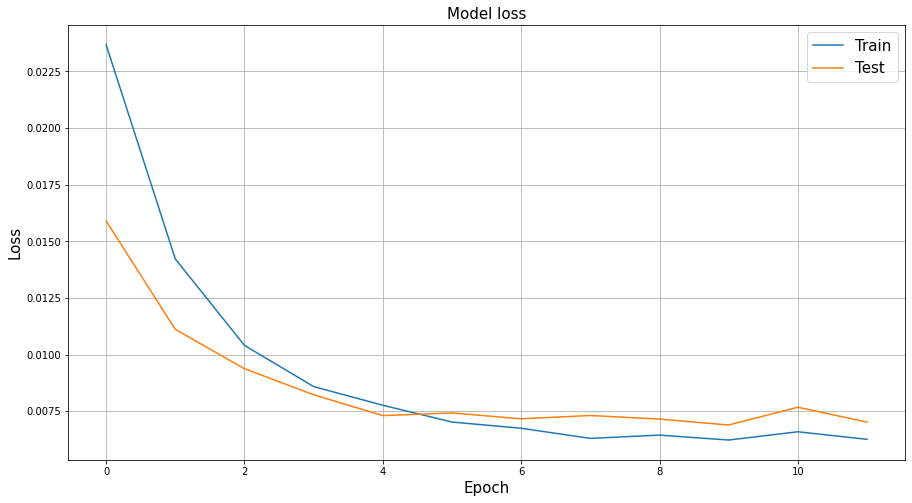

In [34]:
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss',fontsize = 15)
plt.ylabel('Loss',fontsize = 15)
plt.xlabel('Epoch',fontsize = 15)
plt.legend(['Train', 'Test'],fontsize = 15)
plt.grid()
plt.show()